# Lab 5: Sparse Spam Classification 

## Stuart Harley

### Introduction

This notebook provides an example of an app to classify phone SMS messages as either "spam" or "ham" (=not spam).  Some of this content has been adapted from a tutorial by Radimre Hurek:  https://radimrehurek.com/data_science_python/ and has been updated by Dr. Riley.  

In this lab I am training a spam classifier using these text messages.  To do this I am modifying and extending a provided Jupyter Notebook that provides the fundamentals.  I am using a bag-of-words model as a sparse matrix representation of the messages and experimenting with the effect of the sparsity on the storage and performance.

### Learning Outcomes
- An understanding of the basics of training a model
- Using a bag-of-words and TFIDF model in SKLearn
- Adjusting sparsity to understand implications on model accuracy and performance

### Importing Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas
import sklearn
import nltk
import sys
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package punkt to /home/harleys/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/harleys/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/harleys/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Part 1: Load data, explore

Let's get the dataset and put it in the data folder.  ******** instructions to be updated********

This file contains **a collection of more than 5 thousand SMS phone messages** (see the `readme` file for more info).  First, load them using Pandas with one column named `label` and one named `message`...

In [2]:
messages = pandas.read_csv('/data/cs2300/L5/SMSSpamCollection.txt', sep='\t', quoting=csv.QUOTE_NONE,
                           names=["label", "message"])
print(messages)

     label                                            message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5569  spam  This is the 2nd time we have tried 2 contact u...
5570   ham               Will ü b going to esplanade fr home?
5571   ham  Pity, * was in mood for that. So...any other s...
5572   ham  The guy did some bitching but I acted like i'd...
5573   ham                         Rofl. Its true to its name

[5574 rows x 2 columns]


You should take a look at the basic statistics for this dataset using Pandas describe() method

In [3]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4827   4518                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

add a Pandas column that describes the length of the messages

In [4]:
messages["length"] = messages["message"].map(lambda message : len(message))

This will allow you to run the cell below to make a histogram of the length.  

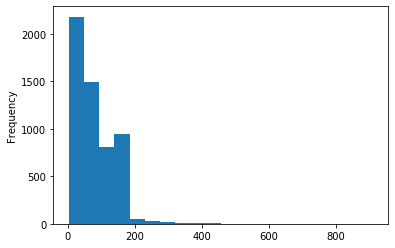

In [5]:
messages.length.plot(bins=20, kind='hist')

In [6]:
messages.length.describe()

count    5574.000000
mean       80.478292
std        59.848302
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

Find and print that really long one...

In [7]:
index = messages["length"].idxmax()
print(messages["message"].iloc[index])

For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later..


We can see if there is there any difference in message length between spam and ham by running the following code to plot them side by side. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbb0cfc3898>,
      dtype=object)

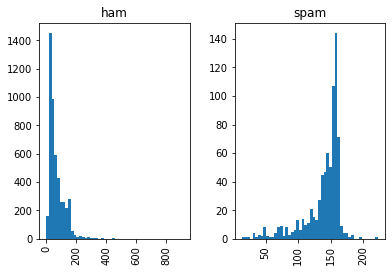

In [8]:
messages.hist(column='length', by='label', bins=50)

Great, but this is not sufficient for us to create a classifier.  We need machine learning!

## Part 2: Data preprocessing

Next we convert the raw messages (sequence of characters) into vectors (sequences of numbers).

The mapping is not 1-to-1; we'll use the [bag-of-words](http://en.wikipedia.org/wiki/Bag-of-words_model) approach, where each unique word in a text will be represented by one number.

As a first step, here is a function that will split a message into its individual words:

In [9]:
def split_into_tokens(message):
    return TextBlob(message).words

You should tokenize them by applying the split_into_tokens method to the message column of the dataframe in the following cell.  Print the results to convince yourself that they are correct.  

In [10]:
messages["message"].map(lambda message : split_into_tokens(message)).head()

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, goes, to, usf, he...
Name: message, dtype: object

With textblob, we can detect [part-of-speech (POS)](http://www.ling.upenn.edu/courses/Fall_2007/ling001/penn_treebank_pos.html) tags with:

In [11]:
TextBlob("Hello world, how is it going?").tags  # list of (word, POS) pairs

[('Hello', 'NNP'),
 ('world', 'NN'),
 ('how', 'WRB'),
 ('is', 'VBZ'),
 ('it', 'PRP'),
 ('going', 'VBG')]

In [12]:
def split_into_lemmas(message):
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

Normalize words into their base form ([lemmas](http://en.wikipedia.org/wiki/Lemmatisation)) by applying the split_into_lemmas function below to the message column of the dataframe

In [13]:
messages["message"].head().map(lambda message : split_into_lemmas(message))

0    [Go, until, jurong, point, crazy, Available, o...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor, U, c, already, t...
4    [Nah, I, do, n't, think, he, go, to, usf, he, ...
Name: message, dtype: object

You can probably think of many more ways to improve the preprocessing: decoding HTML entities (those `&amp;` and `&lt;` we saw above); filtering out stop words (pronouns etc); adding more features, such as an word-in-all-caps indicator and so on.  So keep those in mind for later...

## Part 3: Data to vectors

Now need to convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

Doing that requires essentially three steps, in the bag-of-words model:

1. counting how many times does a word occur in each message (term frequency)
2. weighting the counts, so that frequent tokens get lower weight (inverse document frequency)
3. normalizing the vectors to unit length, to abstract from the original text length


Each vector has as many dimensions as there are unique words in the SMS corpus.  We can count the number of unique words using the following cell...

In [14]:
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(messages['message'])
print(len(bow_transformer.vocabulary_))

11010


Here we used `scikit-learn` (`sklearn`), a powerful Python library for teaching machine learning. It contains a multitude of various methods and options.

Let's take one text message and get its bag-of-words counts as a vector, putting to use our new `bow_transformer`:

In [15]:
message4 = messages['message'][3]
print(message4)

U dun say so early hor... U c already then say...


In [16]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 4189)	2
  (0, 4762)	1
  (0, 5363)	1
  (0, 6219)	1
  (0, 6243)	1
  (0, 7137)	1
  (0, 9280)	2
  (0, 9589)	1
  (0, 10054)	1
(1, 11010)


So, nine unique words are in this message.  Two of them appear twice, the rest only once. 

Write some code in the next cell that identifies the words that appear twice.  

In [17]:
print(bow_transformer.get_feature_names()[4189])
print(bow_transformer.get_feature_names()[9280])

U
say


The bag-of-words counts for the entire SMS corpus are a large, sparse matrix.  In the following cell, calculate the sparsity from the number of non-zero elements (`messages_bow.nnz`) and the shape.  

In [18]:
messages_bow = bow_transformer.transform(messages["message"])
print("sparse matrix shape:", messages_bow.shape)
print("non-zero messages:", messages_bow.nnz)
print("sparsity: %.2f%%" % (100*messages_bow.nnz/(messages_bow.shape[0]*messages_bow.shape[1])))

sparse matrix shape: (5574, 11010)
non-zero messages: 81623
sparsity: 0.13%


Next, lets see what the bow array looks like if we convert it to a "dense" array and print it out.  Lots of 0s right?  We can calculate the storage required by using `sys.getsizeof(array)` so please add that call to the following cell.  

In [19]:
messages_array = messages_bow.toarray()
print(messages_array)
print(sys.getsizeof(messages_array))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
490958032


Term weighting and normalization can be done with [TF-IDF](http://en.wikipedia.org/wiki/Tf%E2%80%93idf), using scikit-learn's `TfidfTransformer`, and we can apply it to the message we used above.  

In [20]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print(tfidf4)

  (0, 10054)	0.22510385070095637
  (0, 9589)	0.1955442748962185
  (0, 9280)	0.49597495370832545
  (0, 7137)	0.4269339327922034
  (0, 6243)	0.3100112284407115
  (0, 6219)	0.2913528957227454
  (0, 5363)	0.2860779240943588
  (0, 4762)	0.25892595706356525
  (0, 4189)	0.391088549792437


To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [21]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5574, 11010)


## Part 4: Training a model, detecting spam

With messages represented as vectors, we can finally train our spam/ham classifier.

We'll be using scikit-learn here, choosing the [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) classifier:

In [22]:
spam_detector = MultinomialNB().fit(messages_tfidf, messages['label'])

Let's try classifying our single random message:

In [23]:
print('predicted:', spam_detector.predict(tfidf4)[0])
print('expected:', messages.label[3])

predicted: ham
expected: ham


Hooray!

A natural question is to ask, how many messages do we classify correctly overall?  The following cell will calculate this for us...

In [24]:
all_predictions = spam_detector.predict(messages_tfidf)
print('accuracy', accuracy_score(messages['label'], all_predictions))

accuracy 0.9721923214926445


There are quite a few possible metrics for evaluating model performance. Which one is the most suitable depends on the task. For example, the cost of mispredicting "spam" as "ham" is probably much lower than mispredicting "ham" as "spam".  Differences between errors can be illuminated using metrics other than accuracy, which we will discuss later.  

## Part 5: Let's get realistic

In the above "evaluation", we committed a cardinal sin. For simplicity of demonstration, we evaluated accuracy on the same data we used for training. **Never evaluate on the same dataset you train on!**

Such evaluation tells us nothing about the true predictive power of our model. If we simply remembered each example during training, the accuracy on training data would trivially be 100%, even though we wouldn't be able to classify any new messages.  This is exactly like memorizing the exact answers for an exam without understanding the underlying material!

A proper way is to split the data into a training/test set, where the model only ever sees the **training data** during its model fitting and parameter tuning. The **test data** is never used in any way -- thanks to this process, we make sure we are not "cheating", and that our final evaluation on test data is representative of true predictive performance.

The following code splits the dataset into a training and testing set.  

In [25]:
msg_train, msg_test, label_train, label_test = \
    train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4459 1115 5574


So, as requested, the test size is 20% of the entire dataset.

Next, lets set up our split datasets to be ready to be used by the Bayes model for training and prediction...

In [26]:
train_messages_bow = bow_transformer.transform(msg_train)
train_tfidf_transformer = TfidfTransformer().fit(train_messages_bow)
train_messages_tfidf = train_tfidf_transformer.transform(train_messages_bow)
test_messages_bow = bow_transformer.transform(msg_test)
test_tfidf_transformer = TfidfTransformer().fit(test_messages_bow)
test_messages_tfidf = test_tfidf_transformer.transform(test_messages_bow)

We can train a new Naive Bayes classifier with only the training data, and test it with the test data, and our accuracy should drop.  In this cell answer: why?

**Answer**: The training data is not as extensive as the full test data, so there are cases in the test data that the system incorrectly classified because it didn't experiance a case similar enough to that in the training data to correctly identify it.

In [27]:
split_spam_detector = MultinomialNB().fit(train_messages_tfidf, label_train)
test_predictions = split_spam_detector.predict(test_messages_tfidf)
print('updated accuracy: %.5f%%' % (accuracy_score(label_test, test_predictions)*100))

updated accuracy: 94.88789%


Next, re-run this experiment changing the test size to a different value (in the subsequent cells of this part) and develop an explanation for the results (it should be different than your accuracy value)

The following code splits the dataset into a new training and testing set. In this case, the test size is 95% of the entire dataset.

In [28]:
msg_train2, msg_test2, label_train2, label_test2 = \
    train_test_split(messages['message'], messages['label'], test_size=.95)

print(len(msg_train2), len(msg_test2), len(msg_train2) + len(msg_test2))

278 5296 5574


The following code set up our split datasets to be ready to be used by the Bayes model for training and prediction.

In [29]:
train_messages_bow2 = bow_transformer.transform(msg_train2)
train_tfidf_transformer2 = TfidfTransformer().fit(train_messages_bow2)
train_messages_tfidf2 = train_tfidf_transformer2.transform(train_messages_bow2)
test_messages_bow2 = bow_transformer.transform(msg_test2)
test_tfidf_transformer2 = TfidfTransformer().fit(test_messages_bow2)
test_messages_tfidf2 = test_tfidf_transformer2.transform(test_messages_bow2)

The following code runs the test data and determines the accuracy of the results. Since the test data is 95% of the entire dataset, it should be expected that the accuracy is lower.

In [30]:
split_spam_detector2 = MultinomialNB().fit(train_messages_tfidf2, label_train2)
test_predictions2 = split_spam_detector2.predict(test_messages_tfidf2)
print('updated accuracy: %.5f%%' % (accuracy_score(label_test2, test_predictions2)*100))

updated accuracy: 86.59366%


## Part 6: Next Steps

In the following cells you should make some changes to the dataset (cast to lowercase, remove numbers, remove non-words, add content, etc) to sufficiently change the sparsity percentage.  The number of columns in your bag of words model should be significantly smaller.  The goal of this is see the size comparison in the non-compressed version of the matrix (`toarray`) vs the sparse representation as the size of the data changes.  If we didn't have a sparse representation, our ability to use a BOW model would be very limiting...

Run the experiments again to assess the accuracy of your new dataset and compare it with your previous results.  You should make arguments about what caused the changes and why they make sense.  Calculate and compare the storage requirements of the non-sparse and sparse representations, and argue how using sparse matricies can enable better accuracy.  

In the following cell is a function to clean a string. This means setting it to lower case and removing non-alphabetic characters.

In [31]:
def clean(message):
    lower = message.lower()
    cleaned = ''
    for letter in lower:
        if letter.isalpha() or letter == " ":
            cleaned += letter
    return cleaned

In the following cell is a function to split a string by spaces

In [32]:
def split(string):
    return string.split()

In the following cell two new dataframe columns are created of cleaned messages and the length of the cleaned messages.

In [33]:
messages["cleaned"] = messages["message"].map(lambda message : clean(message))
messages["cleaned length"] = messages["cleaned"].map(lambda clean : len(clean))

In the following cell I create a new dictionary containing the unique words from the messages and the number of times they occur.

In [34]:
all_words = pd.DataFrame([elem for singleList in list(map(split, messages["cleaned"])) for elem in singleList])
all_words.columns = ["words"]
unique = all_words["words"].value_counts().to_frame()
unique = unique.reset_index()
unique.columns = ["Word", "Occurances"]

In the following cell I identify the words in the bottom 25% of the previous dataframe. These are the words that are used the least in the messages.

In [35]:
last_25 = int(unique.size*.25)
uncommon_words = pd.DataFrame(unique["Word"][-last_25:])
uncommon_words.columns = ["Word"]

In the following cell is a function to remove any word that occurs in the bottom 25% of the used words from a message.

In [36]:
def remove_rare_words(message):
    message_words = message.split()
    result_words = []
    for word in message_words:
        if word not in uncommon_words["Word"].values:
            result_words.append(word)
    return ' '.join(result_words)

In the following cell I create a new column in my original dataframe that contains the messages with the 25% least occurring words removed.

In [37]:
messages["Common"] = messages["cleaned"].map(lambda message : remove_rare_words(message))
messages["Common length"] = messages["Common"].map(lambda message : len(message))

In this cell I count the number of unique words in the "common" messages. As shown the count is 4015, as opposed to 11010 before the messages were cleaned.

In [38]:
bow_transformer3 = CountVectorizer(analyzer=split_into_lemmas).fit(messages['Common'])
print(len(bow_transformer3.vocabulary_))

4013


The bag-of-words counts for the entire SMS corpus are a large, sparse matrix.  In the following cell, I calculate the sparsity from the number of non-zero elements and the shape. As shown in the cell, the sparsity is at .32% as opposed to .13% before the messages were cleaned. This change occured because I removed any non-alphabetic words and the least common words so the number of columns in the matrix was greatly reduced (from 11010 to 4013).

In [39]:
common_bow = bow_transformer3.transform(messages["Common"])
print("sparse matrix shape:", common_bow.shape)
print("non-zero messages:", common_bow.nnz)
print("sparsity: %.2f%%" % (100*common_bow.nnz/(common_bow.shape[0]*common_bow.shape[1])))

sparse matrix shape: (5574, 4013)
non-zero messages: 71376
sparsity: 0.32%


In this cell term weighting and normalization using scikit-learn's `TfidfTransformer` transforms the entire bag-of-words corpus into TF-IDF corpus at once:

In [40]:
tfidf_transformer3 = TfidfTransformer().fit(common_bow)
common_tfidf = tfidf_transformer3.transform(common_bow)
print(common_tfidf.shape)

(5574, 4013)


The following code splits the dataset into a training and testing set that is 20% of the entire dataset.

In [41]:
common_train, common_test, label_train, label_test = \
    train_test_split(messages['Common'], messages['label'], test_size=0.2)

print(len(common_train), len(common_test), len(common_train) + len(common_test))

4459 1115 5574


Next, I set up our split datasets to be ready to be used by the Bayes model for training and prediction.

In [42]:
train_common_bow = bow_transformer3.transform(common_train)
train_tfidf_transformer3 = TfidfTransformer().fit(train_common_bow)
train_common_tfidf = train_tfidf_transformer3.transform(train_common_bow)
test_common_bow = bow_transformer3.transform(common_test)
test_tfidf_transformer3 = TfidfTransformer().fit(test_common_bow)
test_common_tfidf = test_tfidf_transformer3.transform(test_common_bow)

In this cell we test the Naive Bayes classifier with the test data.

In [43]:
split_spam_detector3 = MultinomialNB().fit(train_common_tfidf, label_train)
test_predictions3 = split_spam_detector3.predict(test_common_tfidf)
print('updated accuracy: %.5f%%' % (accuracy_score(label_test, test_predictions3)*100))

updated accuracy: 96.41256%


In this cell I compare the space requirements for the sparce and non-sparce representations.

In [44]:
common_array = common_bow.toarray()
print("bytes in sparse array: " + str(sys.getsizeof(messages_array)))
print("bytes in compressed sparse array: " + str(common_tfidf.data.nbytes))

bytes in sparse array: 490958032
bytes in compressed sparse array: 571008


### Conclusion

- After removing all non-alphabetic words, changing the messages to lowercase, and removing the 25% least common words from the messages, the accuracy of the classification went up from about 94% to about 96%. This makes sense because spam messages usually use the same words that are not commonly found in regular messages. i.e. invest, etc. Spam messages are also often spelled correctly, while regular texts will often use abbreviations and shorten the words. Therefore, while many of the words from the texts will have been removed, the spam messages will be relatively the same and the algorithm is still able to classify them appropriately.

- The sparse array when not compressed takes up 490,958,032 bytes. The compressed version uses only 571,000. The compressed version takes up less storage than the non-compressed form because it is only storing the location of non-zero elements.

- Sparse matrices improve accuracy because they allow for a unique form of storing data that stores both whether a something is contained in the data, but also if it is not. This allows for the data to be used to make comparisons between different values that are being stored in the matrix and in this lab we used it to predict whether or not messages were spam or ham for example.